In [1]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

from scipy.interpolate import interp1d

import random

from sympy import *
    
import io_utilities as ioutil

import warnings
warnings.filterwarnings("ignore")

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

![title](figs/title.png)

<h1><center>Module 07: An Introduction to Interpolation</center></h1>

As a geophysicists or geoscientists, one quickly realizes that it is seldom possible to acquire data exactly at all of the locations where they are wanted (i.e., **spatial sampling** challenges) or at the exact times when you want them (i.e., **temporal sampling** challenges). Unfortunately, this can lead to often significant issues when geophysicists are trying to process acquired data into the final desired format as well as subsequent interpretation. 

Examples of such issues include the following scenarios:
* Acquiring magnetics, gravity, bathymetry or topography data points (e.g., triplets $x$, $y$ and field value $f$) to generate an interpretable 2D map in rectangular coordinates [e.g., $f(x,y)$]. Figure 1 shows the magnetic "track data" acquired during a variety of marine campaigns.  It would be hard to interpret what information is available when shown in this format!

<img src="figs/Magnetic-track-data.jpg" width="750">

**Figure 1. Magnetic track line dataset in the Scotia Arc and surrounding areas (in Mercator projection). Black lines: GEODAS dataset corrected with CM4 model (Quesnel et al., 2009). Red lines: aeromagnetic survey data from the World Magnetic Modeling and Charting Program (carried out from 1951 to 1994). Blue lines: 7 Spanish cruises carried out on board the BIO Hespérides between 1992 and 2008 (figure from Martos et al., 2014)**

* Acquiring a time-series data set at a particular set of points $f(x_0,y_0,t)$ over time when you either cannot get into the field at at the desired time or if there are time intervals when "bad data" are acquired.

<img src="figs/mag_dropouts.jpg" width="750">

**Figure 2. Example of "dropouts" commonly found in magnetics data acqusition.**

* Acquiring 5D seismic data ($t,s_x,s_y,r_x,r_y$) where $s_i$ and $r_i$ are the source and receiver coordinates in the $i=x,y$ direction, where there numerous acquisition challenges (e.g., Land seismic: site access, limited number of receivers, topography, streams; Marine seismic: ocean currents, platforms, naviation challenges).  Figure 3 shows the distribution of source (left) and receiver (right) points for a 3D land seismic survey acquired in Western Australia.  The so-called "acquisition holes" create significant seismic imaging and interpretation challenges.

<img src="figs/SRC_and_REC_DIST.jpg" width="750">

**Figure 3. Irregular sampling on a 3D seismic land survey. Left: The distribution of source points.  Right: the distribution of receiver points.**

One of the most common approaches to handling the challenges posed by **irregular sampling** (in either time or space) is through the use of **interpolation**. Simply put, **interpolation** is nothing but **using the values of data points acquired at known locations to generate an estimates of unknown data points at the desired locations.**

To get an idea of the importance of this topic, one can examine how frequently the work **interpolation** comes in geophysical research journals; a quick survey of the exploration geophysics journal **Geophysics** finds that interpolation is mentioned in 639 different papers between 2014-19 alone.  Not surprisingly, there are many different approaches to interpolation, each with a different degree of approximation accuracy and an associated computational cost.  

Thus, an interesting question to ask is what are the main objectives we are trying to achieve when undertaking interpolation?

##   Interpolation Objectives

When performing interpolation to estimate unknown data values, there are a number of key objectives that should be considered:

* Use the data. finding a missing data value should be guided largely - if not entirely - by the data themselves.
* Honor the data spatially.  Whatever scheme is used, the interpolated data points should match the actual measured values (to within error) at the acquisition locations.
* Honor the data's wavenumbers.  Whatever scheme is used, one should try to honour the wavenumber spectrum of the data (i.e., do not add in significant high-wavenumber information that is not warranted by the data and would be highly spatially aliased).

In the sections below we will examine a number of different approaches for undertaking these tasks.

## What is interpolation?

In many scenarios, data are given only at **discrete control points** such as $(x_0,f(x_0))$, $(x_1,f(x_1))$, $(x_2,f(x_2))$, ..., $(x_{n-1},f(x_{n-1}))$, $(x_n,f(x_n))$. Given this data set, how does one **objectively** estimate the value of $f(x_a)$ at any other value of $x_a$ that is not included at these $x_i$ points? 

Generally speaking, we assume that a single underlying continuous function, $f(x)$, exists on an interval $J: a \le x \le b$ and passes through the $n+1$ data points.  Given this assumption, one can find the value of $f(x_a)$ at any other value of $x_a$ falling in $J: a \le x_a \le b$. The process by which $f(x_a)$ is found is termed **interpolation**.

Note: If a particular point of interest $x_a$ falls outside the range of $J: a \le x \le b$ it is no longer
interpolation but instead is called **extrapolation**, which is a trickier and less stable problem to address and will not be covered in this course.

So what kind of function $f(x)$ should one choose? A **polynomial** of degree $N$, or $p_N(x)$, is a common choice for an **interpolating function**. This is largely because polynomials are easy to evaluate, and when you differentiate or integrate them the result is another polynomial.  Furthermore, using the [Weierstrass approximation theorem](https://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem), one can show that there is a polynomial of sufficiently high degree $n$ such that 

$$\left| f(x) - p_N(x)\right| < \beta, \tag{1}$$

for some positive real error bound $\beta$.  Thus, how do we find such a polynomial $p_N(x)$?

## 1D Lagrange Interpolation

The solution to the 1D interpolation problem dates back to 1795 when [Joseph John Lagrange]() published his tome on the subject (though it was discovered by [Edward Waring](https://en.wikipedia.org/wiki/Edward_Waring) and was a correlary of the work published in 1783 by [Leonhard Euler](https://en.wikipedia.org/wiki/Leonhard_Euler)). In this work Lagrange showed that for a given set of points $(x_{j},f(x_j))$ with no two $x_{j}$ values equal, the **Lagrange polynomial** is a **unique** polynomial of lowest degree that assumes at each value $x_{j}$ the corresponding value $f(x_{j})$ (i.e., the functions coincide at each point).

### General Lagrange Interpolation Polynomial

The value of a function $f(x)$ at point $x$ can be approximated by a polynomial of **order** $n$ - that is, $p_n(x)$ -  according to:

$$f(x) \approx p_n(x) = \sum_{k=0}^{n} L_k(x)f_k = \sum_{k=0}^{n} \frac{l_k(x)}{l_k(x_k)} f_k, \tag{2} $$

where $L_k(x_j) = \delta_{jk}$ (i.e., equals 1 when k=j and 0 otherwise) at the node points such that $f(x_k)=f_k$. This leads to the following values of $l_k(x)$:

$$
\begin{eqnarray}
l_0(x) &=& \Pi_{i=1}^{n} (x-x_i), \tag{3a} \\
l_k(x) &=& \left(\Pi_{i=0}^{k-1} (x-x_i)\right)\left(\Pi_{j=k+1}^{n} (x-x_j)\right), \tag{3b}\\
l_n(x) &=& \Pi_{i=0}^{n-1} (x-x_i), \tag{3c}\\
\end{eqnarray}
$$

where we have used the $\Pi$ summation to express the multiplication of terms (i.e., $\Pi_{k=3}^{5}k = 3\cdot4\cdot5 = 60$). Evidently, at the control points $x=x_k$ we see that equation 2 reduces to 

$$f(x_j) \approx \sum_{k=0}^{n} \frac{l_k(x_j)}{l_k(x_k)} f_k =\sum_{k=0}^{n} \delta_{jk} f_k= f_j. \tag{4} $$

Figure 4 shows some examples that we will explore below: nearest-neighbor interpolation for $n=0$ (left), linear interpolation for $n=1$ (middle), and cubic interpolation for $n=3$ (right).  Comparing linear and cubic interpolation, you will hopefully observe that the higher the order of the interpolating polynomial, the greater number of **control points** or **nodes** are required. In fact, a nth-order polynomial will need $n+1$ unique control points.  This should be quite straightforward to justify: you need two points to define a unique line; you need three points to define a quadratic function; and you need four points to define a cubic function.

<img src="figs/Comparison_of_1D_interpolation.jpg" width="750">

**Figure 4. Schematic of different types of 1D interpolation. Left: Nearest neigthbour $p_0$ (kind of). Center: Linear $p_1$. Right: Cubic $p_3$.**

### Interpolation Error Estimate

The interpolation error estimate $\epsilon_n(x)$ for a general function $f(x)$ is given by:

$$ \epsilon_n(x) = f(x)-p_n(x) = \left(\Pi_{k=0}^{n} (x-x_k) \right) \frac{f^{(n+1)}}{(n+1)}, \tag{5} $$

where $f^{(n+1)}$ is the $(n+1)$ derivative of $f$ evaluated at $x$.  The maximum error is given by the largest values of $\left|f^{(n+1)}\right|$.  Note that equation 5 gives the error for **any** polynomial interpolation method if $f(x)$ has a continuous $(n+1)$ derivative.   

## Example 1 - Linear Interpolation $p_1$

**Q:** You have a $f(x) = \sin x$ function sampled at the following $(x,f(x))$ locations: $(0,0)$, $(\pi/4,1/\sqrt{2})$ and $(\pi/2,1)$. What are the values of the function at $x_a=\pi/8$ and $x_b=3\pi/8$ for a  **linear** Lagrange interpolation scheme at the given control points?

**A:** We can use equation 2 with $n=1$ to write

$$p_1(x) = L_0(x)f_0 + L_1(x) f_1 = \left(\frac{x-x_1}{x_0-x_1}\right) f_0+\left(\frac{x-x_0}{x_1-x_0}\right) f_1 \tag{6a} $$

Using $x_0=0$ and $x_1=\pi/4$, we can calculate the approximate value of the function at $x_a=\pi/8$ via:

$$p_1(\pi/8) = \left(\frac{x-x_1}{x_0-x_1}\right) f_0+\left(\frac{x-x_0}{x_1-x_0}\right) f_1 = \left(\frac{\pi/8-\pi/4}{0-\pi/4}\right) 0 + \left(\frac{\pi/8-0}{\pi/4-0}\right) \frac{1}{\sqrt{2}}=\frac{1}{2\sqrt{2}}. \tag{6b} $$

Now using $x_0=\pi/4$ and $x_1=\pi/2$, we can calculate the approximate value of the function at $x_b=3\pi/8$ via:

$$p_1(3\pi/8) = \left(\frac{x-x_1}{x_0-x_1}\right) f_0+\left(\frac{x-x_0}{x_1-x_0}\right) f_1 = \left( \frac{3\pi/8-\pi/2}{\pi/4-\pi/2}\right) \frac{1}{\sqrt{2}}+\left(\frac{3\pi/8-\pi/4}{\pi/2-\pi/4}\right) 1 = \frac{1}{2}\left(1+\frac{1}{\sqrt{2}}\right). \tag{6c} $$

Let's look at these plotted in the function below.  The black line and stars show the true $f(x) = \sin x$ function and the three control points, respectively.  The red line shows the linear Lagrange interpolating function, while the red stars show the approximations at $x_a=\pi/8$ and $x_b=3\pi/8$. 

According to equation 5, the error associated with these approximations is:

$$\epsilon_1(x_a) = \Pi_{k=0}^{1}(x_a-x_k)\left.\frac{f^2}{2}\right|_{x=x_a} = (\pi/8-0)(\pi/8-\pi/4)\frac{(-\sin \pi/8)}{2} = \frac{\pi^2 \sin \pi/8}{128}=0.0295, \tag{7d}$$
$$\epsilon_1(x_b) = \Pi_{k=0}^{1}(x_b-x_k)\left.\frac{f^2}{2}\right|_{x=x_b} = (3\pi/8-\pi/4)(3\pi/8-\pi/2)\frac{(-\sin 3\pi/8)}{2} = \frac{\pi^2 \sin 3\pi/8}{128}=0.07123, \tag{7e}$$

which are quite close to the exact error estimates of $\epsilon(x_a)=0.02913$ and $\epsilon(x_b)=0.07032$, respectively.

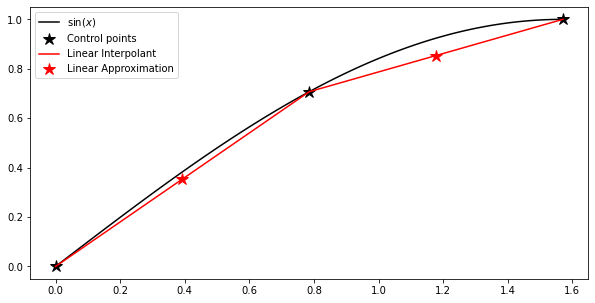

In [2]:
# . . Create true function f(x) using sympy
x = symbols('x')
equation = sin(x)

# . . Create three critical points
criticalpointsX=list((0,np.pi/4,np.pi/2))
criticalpointsY=[equation.subs(x,a) for a in criticalpointsX]

# . . Bring to discrete world
xx = np.linspace(0,np.pi/2,100)
yy = lambdify(x,equation)(xx)

# . . Plot 
plt.figure(figsize=(10,5))
plt.plot(xx,np.transpose(yy),'k')
plt.plot(criticalpointsX,criticalpointsY,'k*',markersize=12)
plt.plot([0,np.pi/4,np.pi/2],[0,1/(np.sqrt(2)),1],'r-',markersize=12)
plt.plot([np.pi/8,3*np.pi/8],[1/(2*np.sqrt(2)),0.5*(1+1/(np.sqrt(2)))],'r*',markersize=12)
plt.legend(['$\sin(x)$','Control points','Linear Interpolant','Linear Approximation'])
plt.show()

## Example 2 - Quadratic Interpolation $p_2$

**Q:** Repeat Example 1, but using a **quadratic** Lagrange interpolation approach.

**A:** We can use equation 2 with $n=1$ to write

$$p_2(x) = L_0(x) f_0 + L_1(x) f_1 + L_2(x) f_2 = 
\left(\frac{(x-x_1)(x-x_2)}{(x_0-x_1)(x_0-x_2)}\right) f_0+
\left(\frac{(x-x_0)(x-x_2)}{(x_1-x_0)(x_1-x_2)}\right) f_1+
\left(\frac{(x-x_0)(x-x_1)}{(x_2-x_0)(x_2-x_1)}\right) f_2 \tag{8a} $$

Using $x_0=0$, $x_1=\pi/4$ and $x_2=\pi/2$, we can calculate the approximate value of the function at $x_a=\pi/8$ via:

$$p_2(\pi/8) = 
\left(\frac{(\pi/8-\pi/4)(\pi/8-\pi/2)}{(0    -\pi/4)(0    -\pi/2)}\right) 0+
\left(\frac{(\pi/8-    0)(\pi/8-\pi/2)}{(\pi/4-    0)(\pi/4-\pi/2)}\right) \frac{1}{\sqrt2}+
\left(\frac{(\pi/8-    0)(\pi/8-\pi/4)}{(\pi/2-    0)(\pi/2-\pi/4)}\right) 1 = \frac{\left(3\sqrt{2}-1\right)}{8} \tag{8b} $$

Similarly, at $x_b=3\pi/8$ we can calculate:

$$p_2(3\pi/8) = 
\left(\frac{(3\pi/8-\pi/4)(3\pi/8-\pi/2)}{(0    -\pi/4)(0    -\pi/2)}\right) 0+
\left(\frac{(3\pi/8-    0)(3\pi/8-\pi/2)}{(\pi/4-    0)(\pi/4-\pi/2)}\right) \frac{1}{\sqrt2}+
\left(\frac{(3\pi/8-    0)(3\pi/8-\pi/4)}{(\pi/2-    0)(\pi/2-\pi/4)}\right) 1 = \frac{3\left(1+\sqrt{2}\right)}{8} \tag{8c} $$

Let's look at these plotted in the function below.  The black line and stars show the true $f(x) = \sin x$ function and the three control points, respectively.  The red line shows the linear Lagrange interpolating function, while the red stars show the approximations at $x_a=\pi/8$ and $x_b=3\pi/8$. 

We can now investigate the errors:

$$\epsilon_2(x_a) = \sin( \pi/8)-\frac{\left(3\sqrt{2}-1\right)}{8}=-0.0226467\tag{8d} $$
$$\epsilon_2(x_b) = \sin(3\pi/8)-\frac{3\left(1+\sqrt{2}\right)}{8}=0.0185494 \tag{8e} $$

which are more accurate than the previous estimates $\epsilon_1(x_a)=0.0295$ and $\epsilon_1(x_b)=0.07032$.

The figure below shows the **quadratic** interpolation results as green stars, and also plots the **linear** interpolation results as red stars.  Evidently, the quadratic interpolation results are more accurate!

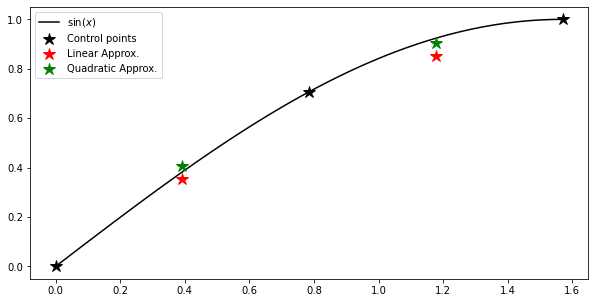

In [3]:
# . . Create true function f(x) using sympy
x = symbols('x')
equation = sin(x)

# . . Create three critical points
criticalpointsX=list((0,np.pi/4,np.pi/2))
criticalpointsY=[equation.subs(x,a) for a in criticalpointsX]

# . . Bring to discrete world
xx = np.linspace(0,np.pi/2,100)
yy = lambdify(x,equation)(xx)

# . . Plot 
plt.figure(figsize=(10,5))
plt.plot(xx,np.transpose(yy),'k')
plt.plot(criticalpointsX,criticalpointsY,'k*',markersize=12)
plt.plot([np.pi/8,3*np.pi/8],[1/(2*np.sqrt(2)),0.5*(1+1/(np.sqrt(2)))],'r*',markersize=12)
plt.plot([np.pi/8,3*np.pi/8],[(3*np.sqrt(2)-1)/8,3*(1+np.sqrt(2))/8],'g*',markersize=12)
plt.legend(['$\sin(x)$','Control points','Linear Approx.','Quadratic Approx.'])
plt.show()

### Computational Considerations

The Lagrangian interpolation approach yields a fairly good approximation to many signals; however, the quality of the interpolation result depends on the effectively sampling of the data and the underlying structure of the function that you are trying to interpolate.  Generally speaking, the lower "frequency" the function is, the lower number of polynomial that you need to represent it with. However, for functions that are effectively sampled near Nyquist, you will need a high degree of polynomial to represent it.  

Numerically speaking, the **computational complexity** of Lagrangian interpolation of order $N$ is given by

$$Cost_{Lagrange_N} = N(N+1)^2 N_{pts} \tag{9} $$

where $N_{pts}$ is the number of points in the 1D array.  Thus, as you get to higher and higher order of approximations, the computational effort per grid point is roughly proportional to $N^3$. This turns out to be very costly for large $N$!  

A further challenge is that as one progresses to higher values of $N$ the interpolating polynomials tend to increasingly oscillate, which can lead to **numerical instability**.  Note that fundamental work in this area of numerical analysis was completed by [Carl Runge](https://en.wikipedia.org/wiki/Carl_David_Tolm%C3%A9_Runge), a famous German mathematician who is better known for his work in ordinary differential equations (ODEs).

## 1D Cubic Spline Interpolation

To address the instability issues associated with "classical" Lagrangian interpolation, a class of novel methods based on **splines** have been developed starting with the important work of Schoenberg (1946). The name spline is borrowed from a **draftman's spline**, which is an elastic rod that is bent to pass through given points and held in place by weights.  The shape that the rod takes then represents the desired mathematical interpolation function.  

The main idea is that instead of using a single high-degree polynomial to approximate the function $f(x)$ over the entire interval of interest 

$$a = x_0 \lt x_1 \lt ... \lt x_n = b, \tag{10}$$

one can use a combination of **n low-degree polynomials** here labeled $q_i(x)$ where $i=1,n$. The key idea is that by fitting polynomials together to form an interpolating function $g(x)$ called a **spline** where that passes through the data points:

$$ g(x_0)=f(x_0) = f_0, \quad g(x_1)=f(x_1) = f_1, \quad ..., \quad g(x_n)=f(x_n) = f_n \tag{11}$$

Thus, **spline interpolation** is a form of *piecewise smooth polynomial interpolation*. The main practical question is the what type of polynomials should we use? It is hopefully evident that **linear spline interpolation** functions would not be sufficient to represent curved surfaces (largely because the first derivative of the interpolation function is a constant). 

Rather, we look for interpolation polynomial that allows for non-zero and continuous first and second derivatives that allow use to express ideas like slope and curvature. This is the now very widely used **cubic spline interpolation** method.   

A further condition that we require is that we can specify the values of the tangent directions (i.e., the slopes) at the two endpoints:

$$ g^\prime(x_0) = k_0 \quad {\rm and} \quad g^\prime(x_n) = k_n \tag{12}.$$

Given these requirements, there is one and only one cubic spline that can satisfy the conditions given in equations 10-12.

Let's now look at an example when there are eight points (i.e., $n=7$):

<img src="figs/Cubic_Splines.png" width="500">

**Figure 3. Illustration of the strategy of cubic splines.  Starting at the top. Let's say that we have a bunch of points $f(x_0), f(x_1), ... f(x_7)$ that correspond to some underlying $f(x)$ along with the slopes at the start $k_0$ and at the end $k_7$.  In this case, the aim of cubic splines is to find seven cubic polynomials $q_i(x)$ each of which applies on the interval shown in orange. Taken collectively, these seven polynomials will form a complete function $g(x)$ that is a very good approximation to the true $f(x)$. However, a key constraint is the cubic polynomial at the start/end points of each orange section must be piecewise continuous and have the same slope as the corresponding points in the neighbouring orange sections. Given this setup, there is one and only one cubic polynomial that satisfies this in each interval: the cubic spline.**


### Existence and Uniqueness of Cubic Splines

**THEOREM**: Let $f_j = f(x_j)$ be arbitrarily spaced data points at given $x_j$. Let $k_0$ and $k_n$ be any given numbers.  Then there is one and only one cubic spline $g(x)$ corresponding to equation 10, 11 and 12. 
$$
$$

**PROOF**: By definition, on every subinterval $I_j$ given by $x_j \le x\le x_{j+1}$ the spline $g(x)$ must agree with polynomial $q_j(x)$ of degree not exceeding 3 such that:

$$$$
$$
\begin{eqnarray} q_j(x_j) = f(x_j),\quad {\rm and} \quad  q_j(x_{j+1}) = f(x_{j+1}) \quad {\rm for} \quad j=0,n-1 \end{eqnarray} \tag{13}
$$
$$$$

For the derivatives we write

$$$$
$$q_j^\prime(x_j) = k_j \quad {\rm and} \quad q_j^\prime(x_{j+1}) = k_{j+1} \quad {\rm for} \quad j=0,n-1 \tag{14} $$
$$$$

with $k_0$ and $k_n$ given and $k_1, ..., k_{n-1}$ to be determined later. Equations 13 and 14 are found conditions for each $q_j(x)$.  By direct calculation, using the notation 

$$$$
$$c_j = \frac{1}{h_j} = \frac{1}{x_{j+1}-x_j}, \quad j=0,n-1 \tag{15}$$
$$$$

we can verify that the unique cubic polynomial $q_j(x)$ satifying equation 13 and 14 is
$$$$
$$q_j(x) = f(x_j) c_j^2 \left(x-x_{j+1}\right)^2\left[1+2c_j(x-x_j)\right] + f(x_{j+1})c_j^2(x-x_j)^2\left[1-2c_j(x-x_{j+1})\right] + k_j c_j^2 \left(x-x_j\right)\left((x-x_{j+1}\right)^2+k_{j+1}c_j^2\left(x-x_j\right)^2\left(x-x_{j+1}\right). \tag{16}$$
$$$$

Differentiating twice we obtain
$$$$
$$q_j^{\prime\prime}(x_j) = 6c_j^2\left[f(x_{j+1})-f(x_j)\right]-4c_jk_j-2c_jk_{j+1} \tag{17}$$
$$$$
$$q_j^{\prime\prime}(x_{j+1}) =-6c_j^2 \left[f(x_{j+1})-f(x_j)\right]+2c_j k_j -+4c_jk_{j+1} \tag{18}$$
$$$$

By definitions, $g(x)$ has continuous second derivaties, which gives rise to the conditions:
$$$$

$$q_{j-1}^{\prime\prime}(x_j) = q_j^{\prime\prime}(x_j), \quad j=1,n-1 \tag{19}$$
$$$$

If we use equation 18 with $j$ replaced by $j-1$ and equation 17 then these $n-1$ equations become

$$$$
$$c_{j-1}k_{j-1} + 2(c_{j-1}+c_j)k_j+ c_j k_{j+1} = 3 \left[c^2_{j-1}\nabla f_j + c_j^2\nabla f_{j+1}\right] \quad {\rm for} \quad j=1,n-1, \tag {20}$$
$$$$
where $\nabla f_j = f(x_j) - f(x_{j-1})$ and $\nabla f_{j+1} = f(x_{j+1}) - f(x_j)$.

This is a **linear**, **sparse** and **tridiagonal** system of $n-1$ equations that has a unique solution for $k_i, i=1,n-1$.  This is a diagonally dominant system  where the diagonal is greater than the sum of the other offdiagonal components.  Finally, because the determinant cannot be zero, the above values must represent the *unique* solution. 


### What this theorem means in practice

Without going into the details of the proof above, the key point takeaway message is that given:

   * the data points $f(x_j)$, and 
   * the values of derivatives (i.e., slopes) at the end points $k_0$ and $k_{n-1}$, 

the solution to the cubic spline is determined by derivatives of the interpolating function $g(x)$ at all of the interior points $k_i$ where $i=1,n-1$ is given by:

$$c_{j-1}k_{j-1} + 2(c_{j-1}+c_j)k_j+ c_j k_{j+1} = 3 \left[c^2_{j-1}\nabla f_j + c_j^2\nabla f_{j+1}\right] \quad {\rm for} \quad j=1,n-1 \tag {21}$$

where function differences $\nabla f_j = f(x_j) - f(x_{j-1})$ and $\nabla f_{j+1} = f(x_{j+1}) - f(x_j)$ and the sample spacing $c_j = \frac{1}{h_j} = \frac{1}{x_{j+1}-x_j}$ are all known quantities.

Let's look at this for a system where $n=5$ where $k_0=\alpha$ and $k_5=\beta$ **in matrix form**:

$$
\left[
\begin{array}{cccccc}
1 & 0 & 0        & 0          & 0          & 0 \\
c_0 & 2(c_0+c_1) & c_1        & 0          & 0          & 0 \\
0   &  c_1       & 2(c_1+c_2) & c_2        & 0          & 0 \\
0   &  0         & c_2        & 2(c_2+c_3) & c_3        & 0 \\
0   &  0         & 0          & c_3        & 2(c_3+c_4) & c_4 \\
0   &  0         & 0          & 0       & 0 & 1 \\
\end{array}
\right]
\left[
\begin{array}{c}
\alpha \\
k_1 \\
k_2 \\
k_3 \\
k_4 \\
\beta
\end{array}
\right]
=
3
\left[
\begin{array}{c}
\alpha/3\\
c_0^2(f_1-f_0)+c_1^2(f_2-f_1)\\
c_1^2(f_2-f_1)+c_2^2(f_3-f_2)\\
c_2^2(f_3-f_2)+c_3^2(f_4-f_3)\\
c_3^2(f_4-f_3)+c_4^2(f_5-f_4)\\
\beta/3\\
\end{array}
\right]. \tag{22}
$$

Another way to write this is compactly in the form

$${\bf Ck}={\bf f} \tag{23}$$

where ${\bf C}$ is the sampling matrix, ${\bf k}$ is the unknown gradient vector and ${\bf f}$ are the data values in vector form.  Here we have 4 unknown ${\bf k}$ values and 4 constraint equations (plus two trivial end slope equations).  Thus, as shown in the proof above, this system has a unique solution. 

There are two interesting observations regarding this systems of equations:
1. You'll note that this is a [system of linear equations](https://en.wikipedia.org/wiki/System_of_linear_equations) in that matrix ${\bf C}$ does not depend on ${\bf k}$.  These types of systems are much easier to solve than their non-linear counterpart.  We have already looked at solving such systems in the Linear Algebra section of the course.
2.  You'll also note that there is clearly a structure to matrix ${\bf C}$, which is termed a [tridiagonal matrix](https://en.wikipedia.org/wiki/Tridiagonal_matrix). In this case there is the banded matrix stucture along the main diagonal and the ones immediately above and below it.  This matrix structure is well studied and has a quite straightforward solution using the [Thomas Algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm).
3. A second observations is that ${\bf C}$ is clearly a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) in that even as the dimension of the matrix grows as $N x N-2$ there will only be at most 3 non-zero elements per row.  This structure is advantageous in that the memory $\mathcal{M}$ required to store matrix is $\mathcal{M} = 3N$ rather than the  $\mathcal{M} \approx N^2$ required to store the full matrix.  This becomes very important when $N$ is, say, a billon elements!


### Equidistant sampling

In scenarios where you have sampling at uniform intervals, we can simplify the above cubic spline because $h_j=h$ is uniform throughout the grid.  In this case, this means that $c_j = \frac{1}{h}$ and we can rewrite equation 20 as

$$k_{j-1} + 4 k_j + k_{j+1} = \frac{3}{h}\left(f_{j+1} - f_{j-1}\right) \quad {\rm where} \quad j=1,n-1, \tag{28} $$

equation 21 as:

$$
\left[
\begin{array}{cccccc}
1     &     0    &      0       & 0 & 0 & 0\\
\frac{1}{h} & 2(\frac{1}{h}+\frac{1}{h}) & \frac{1}{h}        & 0          & 0          & 0 \\
0   &  \frac{1}{h}       & 2(\frac{1}{h}+\frac{1}{h}) & \frac{1}{h}        & 0          & 0 \\
0   &  0         & \frac{1}{h}        & 2(\frac{1}{h}+\frac{1}{h}) & \frac{1}{h}        & 0 \\
0   &  0         & 0          & \frac{1}{h}        & 2(\frac{1}{h}+\frac{1}{h}) & \frac{1}{h} \\
0 & 0 & 0 & 0 & 0 & 1\\
\end{array}
\right]
\left[
\begin{array}{c}
\alpha \\
k_1 \\
k_2 \\
k_3 \\
k_4 \\
\beta
\end{array}
\right]
=
3
\left[
\begin{array}{c}
\alpha/3\\
\frac{1}{h}^2(f_1-f_0)+\frac{1}{h}^2(f_2-f_1)\\
\frac{1}{h}^2(f_2-f_1)+\frac{1}{h}^2(f_3-f_2)\\
\frac{1}{h}^2(f_3-f_2)+\frac{1}{h}^2(f_4-f_3)\\
\frac{1}{h}^2(f_4-f_3)+\frac{1}{h}^2(f_5-f_4)\\
\beta/3\\
\end{array}
\right]. \tag{29}
$$

which simplifies to

$$
\left[
\begin{array}{cccccc}
1 & 0 & 0 & 0 & 0 & 0 \\
1 & 4 & 1 & 0 & 0 & 0 \\
0 & 1 & 4 & 1 & 0 & 0 \\
0 & 0 & 1 & 4 & 1 & 0 \\
0 & 0 & 0 & 1 & 4 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{array}
\right]
\left[
\begin{array}{c}
\alpha \\
k_1 \\
k_2 \\
k_3 \\
k_4 \\
\beta
\end{array}
\right]
=
\frac{3}{h}
\left[
\begin{array}{c}
h\alpha/3\\
(f_2-f_0)\\
(f_3-f_1)\\
(f_4-f_2)\\
(f_5-f_3)\\
h\beta/3\\
\end{array}
\right], \tag{30}
$$

as is required by equation 28.

### End conditions

The final condition that we need to specify is the behaviour at the boundaries.  The two main types of boundary behavior includes the **clamped conditions**:

$$g^\prime(x_0) = f^\prime(x_0) \quad {\rm and} \quad g^\prime(x_n) = f^\prime(x_n) \tag{24}$$

and the **free** or **natural conditions**:

$$g^{\prime\prime}(x_0) = 0 \quad {\rm and} \quad g^{\prime\prime}(x_n) = 0 \tag{25}$$

Below we are only concerned about using the clamped conditions.

### Determination of splines

Now that we have all of the components, we can put together a two-step solution system for spline interpolation. Let's assume that we have a number of data points as well and that $k_0$ and $k_n$ are given.  

* Step 1: The first solution step is to obtain $k_i, i=1,n-1$ by solution the linear system in equation 21 or 22.
* Step 2: We now need to find the $n$ cubic polynomials $q_0, ..., q_{n-1}$ that define the interpolation function $g(x)$.  These polynomials are of the form:

$$q_j(x) = a_{j0} + a_{j1}(x-x_j)+a_{j2}(x-x_j)^2 + a_{j3}(x-x_j)^3 \quad {\rm where}\quad j=0,n-1. \tag{26}$$

Here, $a_{j0}, a_{j1}, a_{j2}$ and $a_{j3}$ are coefficients that can be found using Taylor's formula:

$$
\begin{eqnarray}
a_{j0} &=& q_j(x_j) &= & f_j \tag{27a} \\
a_{j1} &=& q^\prime_j(x_j) &= &k_j  \tag{27b} \\
a_{j2} &=& \frac{1}{2}q_j^{\prime\prime}(x_j) &=& \frac{3}{h_j^2}\left(f_{j+1}-f_j\right) - \frac{1}{h_{j+1}}\left(k_{j+1}+2k_j\right)  \tag{27c} \\
a_{j3} &=& \frac{1}{6}q_j^{\prime\prime\prime} (x_j) &=& \frac{2}{h_j^3}\left(f_j-f_{j+1}\right) + \frac{1}{h_j^2}\left(k_{j+1}+k_j\right) \tag{27d} 
\end{eqnarray}
$$

which are (27a) the function values at known points; (27b) the computed slopes at the known points; and (27c) and (27d) a combination of the function and slope values at known points, respectively.

## Analytical Example - Spline Interpolation for Equidistant Nodes

**Q** Interpolate $f(x)=x^4$ on the interval $-1\le x\le 1$ by the cubic spline $g(x)$ corresponding to nodes $x_0=-1$, $x_1=0$ and $x_2=1$ and satisfying the clamped conditions $g^\prime(-1) = f^\prime(-1)$ and $g^\prime(1) = f^\prime(1)$.

**A** In this **equidistant** sampling scenario we are given data $[f_0,f_1,f_2] = [f(-1),f(0),f(1)] = [1,0,1]$. We also have $h=1$ and $n=2$ polynomials.  We also can compute the derivatives of the function  as $f^\prime(x)=4x^3$ and thus $k_0=f^\prime(x_0) = 4x_0^3 = -4$ and $k_2= f^\prime(x_2) =  4x_2^3 = 4$. We can now do our two-step solution discussed above:

STEP 1: Using equation 27 we need to solve only on equation to find the single unknown quantity $k_1$.  This can be done according to:

$$k_{j-1} + 4 k_j + k_{j+1} = \frac{3}{h}\left(f_{j+1} - f_{j-1}\right) \quad {\rm where} \quad j=1,n-1, \tag{31a} $$

which specifically for this case is:

$$k_0 + 4k_1 +k_2 = 3(f_2-f_0) \tag{31b} $$

Substituting in our values for $k_0$, $k_2$, $f_0$ and $f_2$ yields

$$ -4 + 4k_1 + 4 = 3(1-1) = 0, \tag{31c} $$

and thus

$$k_1=0. \tag{31d}$$

STEP 2: Now that we know all of the $k_j, j=0,n$ values, we can compute the polynomials according to equations 26 and 27. Equation 26 gives us the follow two equations:

$$
\begin{eqnarray}
q_0(x) &=& a_{00} + a_{01}(x+1)+ a_{02}(x+1)^2+ a_{03}(x+1)^3, & \quad -1\le x \le 0, \tag{32a}\\
q_1(x) &=& a_{10} + a_{11} x   + a_{12}    x^2+ a_{13}    x^3, & \quad  0\le x \le 1, \tag{32b}\\
\end{eqnarray}
$$

where the $a_{ij}$ values are given by equations 26). 

For $j=0$ we get:

$$
\begin{eqnarray}
a_{00} &=& q_0(x_0) &= & f_0 &=&1 \tag{33a} \\
a_{01} &=& q^\prime_0(x_0) &= &k_0 &=& -4 \tag{33b} \\
a_{02} &=& \frac{1}{2}q_0^{\prime\prime}(x_0) &=& \frac{3}{h^2}\left(f_{1}-f_0\right) - \frac{1}{h}\left(k_1+2k_0\right) &=& \frac{3}{1}(0-1)-\frac{1}{1}(0+2\cdot(-4))=5 \tag{33c} \\
a_{03} &=& \frac{1}{6}q_0^{\prime\prime\prime} (x_0) &=& \frac{2}{h^3}\left(f_0-f_1\right) + \frac{1}{h^2}\left(k_1+k_0\right)&=&\frac{2}{1}\left(1-0\right) + \frac{1}{1}\left(0-4\right)= -2\tag{33d} 
\end{eqnarray}
$$

For $j=1$ we obtain

$$
\begin{eqnarray}
a_{10} &=& q_1(x_1) &= & f_1  &=& 0 \tag{34a} \\
a_{11} &=& q^\prime_1(x_1) &= &k_1 &=& 0 \tag{34b} \\
a_{12} &=& \frac{1}{2}q_1^{\prime\prime}(x_1) &=& \frac{3}{h^2}\left(f_{2}-f_1\right) - \frac{1}{h}\left(k_{2}+2k_1\right) &=& \frac{3}{1}\left(1-0\right) - \frac{1}{1}\left(4+2\cdot 0\right) = -1 \tag{34c} \\
a_{13} &=& \frac{1}{6}q_j^{\prime\prime\prime} (x_1) &=& \frac{2}{h^3}\left(f_1-f_2\right) + \frac{1}{h^2}\left(k_{2}+k_1\right) &=& \frac{2}{1}\left(0-1\right) + \frac{1}{1}\left(4+0\right) =2 \tag{34d} 
\end{eqnarray}
$$

Thus, the overall cubic spline $g(x)$ is given by:

$$
\begin{eqnarray}
g(x) &= \left\{
\begin{array}{c}
q_0(x) = &1-4(x+1)+5(x+1)^2-2(x+1)^3 = -x^2-2x^3  \quad & {\rm if} &\quad -1 \le x \le 0   \\
q_1(x) = & -x^2+2x^3                              \quad & {\rm if} &\quad 0  \le x \le 1   \\
\end{array}
\right.
\end{eqnarray} \tag{35}
$$

## Numerical Example 1 - Cubic Spline Interpolation for Equidistant Nodes

Let's now see how well the 1D cubic spline interpolation from the analytical example above actually performs.  Here, I've generated the original function $f(x) = x^4$ and the three control points $[x_0,x_1,x_2]=[-1,0,1]$ where clearly $[f_0,f_1,f_x]=[1,0,1]$. I've then hard-coded the approximation fuctions.

In [4]:
## . . Define function
def x4(x):
     return x**4

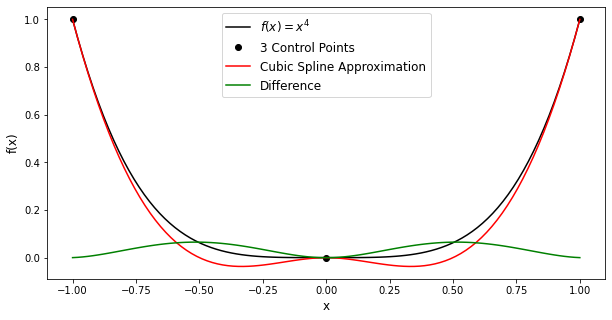

In [5]:
## . . Full function
xden = np.linspace(-1,1,100,endpoint=True)
fden = x4(xden)

## . . Control points
xcontrol = np.linspace(-1,1,3)
fcontrol = x4(xcontrol)

##############################
## Spline Approx
# . . Define on first interval
x0 = np.linspace(-1,0,50)
q0 = -x0**2-2*x0**3

# . . Define on second interval
x1 = np.linspace(0,1,50)
q1 = -x1**2+2*x1**3

## . . Concatenate x and g(x)
xx = np.concatenate((x0,x1),axis=0)
gx = np.concatenate((q0,q1),axis=0)

plt.figure(figsize=(10,5))
plt.plot(xden,fden,'k')
plt.plot(xcontrol,fcontrol,'ko')
plt.plot(xx,gx,'r')
plt.plot(xden,fden-gx,'g')
plt.xlabel('x',fontsize=12)
plt.ylabel('f(x)',fontsize=12)
plt.legend(['$f(x)=x^4$','3 Control Points','Cubic Spline Approximation','Difference'],fontsize=12)
plt.show()

We see that the approximating function does pretty well in estimating the overall shape of the curve. We see that it exactly matches the values and the slopes at the three control points.  However, the cubic spline interpolation operation would definitely benefit from having additional contol points!  Let's now use the the built-in spline interpolation tools in the *scipy.interpolate* library.

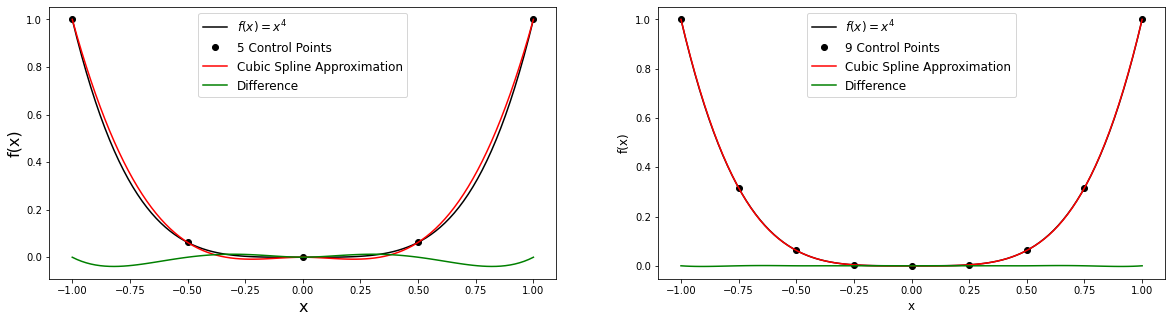

In [6]:
def test_splines_uniform(nnodes,kind,xden):
    ## . . Define n control points
    xcont = np.linspace(-1,1,nnodes)
    fcont = x4(xcont)
    
    ## . . Use these points to define the cubic spline interpolation
    f2 = interp1d(xcont, fcont, kind=kind)

    ## . . Now let's use these on the original dense sampling (xden) to come up with the cubic spline interpolation
    gx = f2(xden)
    
    return xcont,fcont,gx


## . . Test with 4 control points
xc5,fc5,gx5 = test_splines_uniform(5,'cubic',xden)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(xden,fden,'k')
plt.plot(xc5,fc5,'ko')
plt.plot(xden,gx5,'r')
plt.plot(xden,fden-gx5,'g')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.legend(['$f(x)=x^4$','5 Control Points','Cubic Spline Approximation','Difference'],fontsize=12)

## . . Test with 9 control points
xc9,fc9,gx9 = test_splines_uniform(9,'cubic',xden)

plt.subplot(122)
plt.plot(xden,fden,'k')
plt.plot(xc9,fc9,'ko')
plt.plot(xden,gx9,'r')
plt.plot(xden,fden-gx9,'g')
plt.xlabel('x',fontsize=12)
plt.ylabel('f(x)',fontsize=12)
plt.legend(['$f(x)=x^4$','9 Control Points','Cubic Spline Approximation','Difference'],fontsize=12)


plt.show()

As one might have suspected, the greater number of control points or "nodes", the better the overall interpolation approximation. 

## Numerical Example 2 - Cubic Spline Interpolation for Irregularly Sampled Nodes


We can now explore some interesting variations to this example.  For instance, what happens when the control point / nodes are irregularly spaced? 

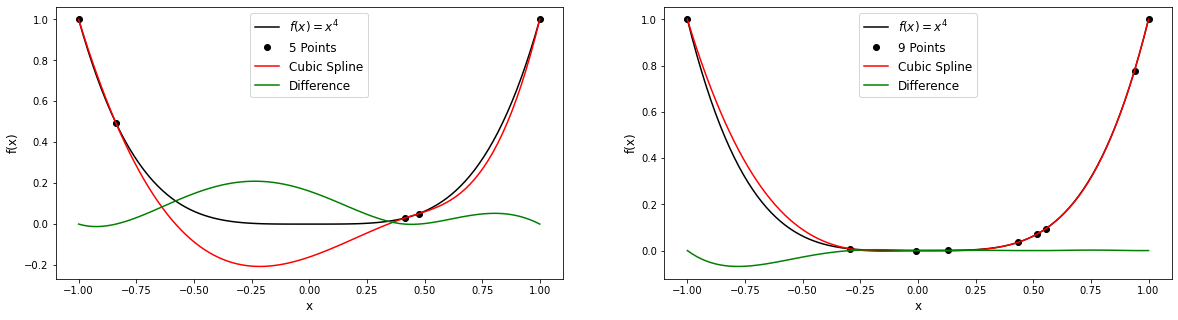

In [20]:
def test_splines_irregular(nnodes,kind,xden):

    ## . . Define n control points by randomly selecting from xden.
    ## . . Then force the first and last points to be -1 and 1, repectively.
    xcont = np.sort(random.sample(set(xden),nnodes))
    xcont[0],xcont[-1]=-1,1
    fcont = x4(xcont)
    
    ## . . Use these points to define the cubic spline interpolation
    f2 = interp1d(xcont, fcont, kind=kind)

    ## . . Now let's use these on the original dense sampling (xden) to come up with the cubic spline interpolation
    gx = f2(xden)
    
    return xcont,fcont,gx

## . . Test with 5 control points
xc5,fc5,gx5 = test_splines_irregular(5,'cubic',xden)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(xden,fden,'k')
plt.plot(xc5,fc5,'ko')
plt.plot(xden,gx5,'r')
plt.plot(xden,fden-gx5,'g')
plt.xlabel('x',fontsize=12)
plt.ylabel('f(x)',fontsize=12)
plt.legend(['$f(x)=x^4$','5 Points','Cubic Spline','Difference'],fontsize=12)

## . . Test with 9 control points
xc9,fc9,gx9 = test_splines_irregular(9,'cubic',xden)

plt.subplot(122)
plt.plot(xden,fden,'k')
plt.plot(xc9,fc9,'ko')
plt.plot(xden,gx9,'r')
plt.plot(xden,fden-gx9,'g')
plt.xlabel('x',fontsize=12)
plt.ylabel('f(x)',fontsize=12)
plt.legend(['$f(x)=x^4$','9 Points','Cubic Spline','Difference'],fontsize=12)

plt.show()

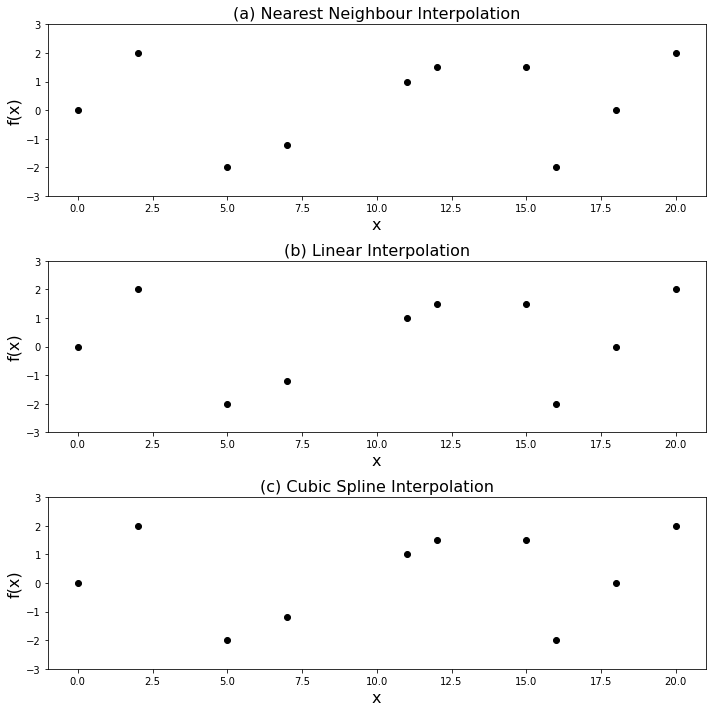

In [21]:
x = np.zeros(10)
x = [0,2,5,7,11,12,15,16,18,20]
f = np.zeros(10)
f = [0,2,-2,-1.2,1,1.5,1.5,-2,0,2]

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(x,f,'ko')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.title('(a) Nearest Neighbour Interpolation',fontsize=16)
plt.ylim(-3,3)

plt.subplot(312)
plt.plot(x,f,'ko')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.title('(b) Linear Interpolation',fontsize=16)
plt.ylim(-3,3)

plt.subplot(313)
plt.plot(x,f,'ko')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.title('(c) Cubic Spline Interpolation',fontsize=16)
plt.ylim(-3,3)

plt.tight_layout()
#plt.savefig('interpolation.png')

plt.show()

## Numerical Example 3 - Order of Spline Interpolation


Finally, we can ask the question: "How does **cubic** spline interpolation (n=3) compare to **lower-order** spline methods where n=0,1,2?" Let's redo the example above, but calling different orders.

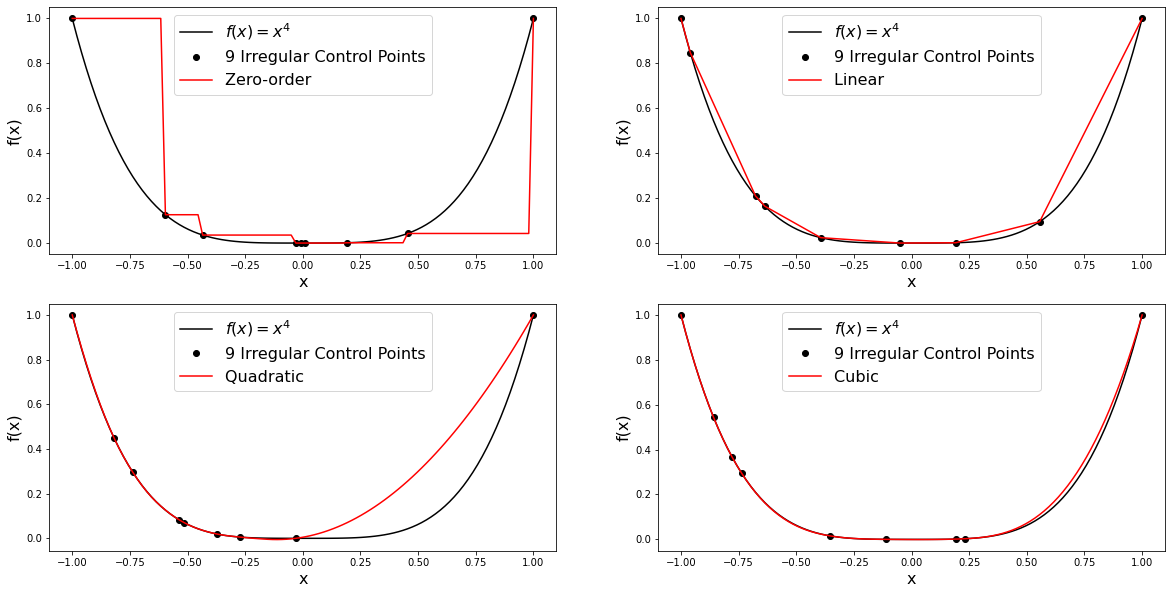

In [22]:
## . . Test with 9 control points
xc0,fc0,gx0 = test_splines_irregular(9,'zero',xden)
xc1,fc1,gx1 = test_splines_irregular(9,'slinear',xden)
xc2,fc2,gx2 = test_splines_irregular(9,'quadratic',xden)
xc3,fc3,gx3 = test_splines_irregular(9,'cubic',xden)

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(xden,fden,'k')
plt.plot(xc0,fc0,'ko')
plt.plot(xden,gx0,'r')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.legend(['$f(x)=x^4$','9 Irregular Control Points','Zero-order '],fontsize=16)

plt.subplot(222)
plt.plot(xden,fden,'k')
plt.plot(xc1,fc1,'ko')
plt.plot(xden,gx1,'r')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.legend(['$f(x)=x^4$','9 Irregular Control Points','Linear '],fontsize=16)

plt.subplot(223)
plt.plot(xden,fden,'k')
plt.plot(xc2,fc2,'ko')
plt.plot(xden,gx2,'r')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.legend(['$f(x)=x^4$','9 Irregular Control Points','Quadratic '],fontsize=16)

plt.subplot(224)
plt.plot(xden,fden,'k')
plt.plot(xc3,fc3,'ko')
plt.plot(xden,gx3,'r')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.legend(['$f(x)=x^4$','9 Irregular Control Points','Cubic '],fontsize=16)
plt.show()

Again, it seems pretty clear that the higher-order methods win the day!  Looking at the first panel, you might be wondering *what does a zeroth-order polynomial actually mean*?  Good question! This represents a fairly common  method called **nearest-neighbor interpolation**.  I will briefly touch on this topic next for completeness.

## 1D Nearest Neighbour Interpolation

Another very basic form of 1D interpolation to be aware of is the "nearest neighbour" approach.  This is probably pretty much as it seems: fill in missing values with those nearest. 

More mathematically, let's say that we are given a set of n points $f_i(x_i), i=0,n-1$, assume that the unknown interpolated value at $f(x)$ is given by the value $f(x_i)$ to the point $x_i$ that minimizes $|x-x_i|$.  Basically, the computational cost of this approach comes down the cost of the sorting algorithm used. 

Let's look at an example below where we fully and then randomly subsample function $f(x) = x(1-x)\cos(4\pi x)$:

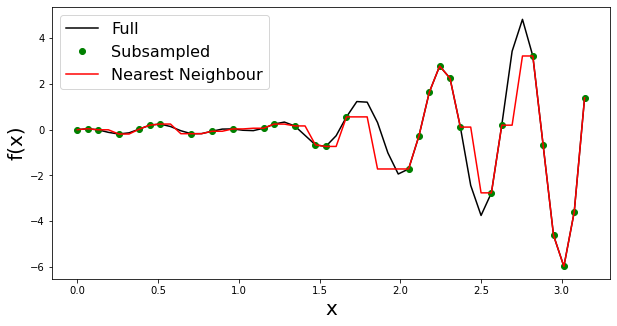

In [10]:
# . . Define a random function
def randfunc(x):
     return x*(1-x)*np.cos(4*np.pi*x)

# . . Define 1D grid and define the function over it
xx = np.linspace(0,np.pi,50,endpoint=True)
ff = randfunc(xx)

# . . Select npts random points from normal distribution, sort, and then grab the funcion values at that location
npts = 30;
points = np.sort(random.sample(set(xx), npts))
values = randfunc(points)

# . . Define nearest neighbour interpolation on random grid and then apply approximation to full grid
nn_interp = interp.interp1d(points, values, kind='nearest',fill_value="extrapolate")
nn_interpolated = nn_interp(xx)

# . . Plotting 
plt.figure(figsize=(10,5))
plt.plot(xx,ff,'k') ## . .  the original function
plt.plot(points, values,'go') ## . . Randomly subsampled function
plt.plot(xx,nn_interpolated,'r') ## . . Nearest neighbour approximation
plt.legend(['Full','Subsampled','Nearest Neighbour'],fontsize=16)
plt.xlabel('x',fontsize=20)
plt.ylabel('f(x)',fontsize=20)
plt.show()

While this naive approach has clearly infilled the missing data points and somewhat takes the shape of the function it clearly yields some pretty low quality results.   Overall, this approach gives fairly low accuracy results, but can be a quick and dirty solution for very large data sets or where the solution is a slowly varying function (relative to the exising spatial sampling).

# 2D Interpolation

Just as geophysical data sets are not limited to 1D acquisition, there is also a need for interpolation in higher dimensions. Fortunately, most types of 1D interpolation can be extended to 2D and even higher dimension in a fairly straightforward fashion. (You can recognize them by putting "bi" in front of the algorithm!)  Figure 6 presents a comparison of 1D and 2D interpolation types analogous to those presented in Figure 2-5. 

Looking at the middle panels, it is clear that performing 2D bilinear interpolation ($n_x=n_y=1$) requires a higher number of points. In this case, we see that the operation is defined by $(n_x+1)(n_y+1)=4$ control points. Similarly, for bicubic interpolation $n_x=n_y=3$, we see that the operation is defined by $(n_x+1)(n_y+1)=16$ control points. Clearly, the computational complexity of these operations are going to scale proportional to $(n+1)^2$.   

<img src="figs/Comparison_of_1D_and_2D_interpolation.png" width="600">

**Figure 6. Schematic of different types of 1D and 2D interpolation. Upper left: 1D nearest-neighbor interpolation (n=0). Upper middle: 1D linear interpolation (n=1). Upper right: 1D cubic interpolation (n=3).  Lower left: 2D nearest-neighbor interpolation ($n_x=n_y=0$). Lower middle: 2D linear interpolation ($n_x=n_y=1$). Lower right: 2D cubic interpoloation ($n_x=n_y=3$).**


## Bilinear Interpolation

Let's start with one of the more straighforward approaches that we examined above: 1D linear Lagrangian interpolation. In 2D applications, this is called [bilinear interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation) since it is a **bidirectional** approach. 

**PROBLEM**: Let's set up the problem according to Figure 2-7. Say you have data values $f(Q_{ij})$ at four control points $Q_{11}=(x_1,y_1)$, $Q_{21}=(x_2,y_1)$, $Q_{12}=(x_1,y_2)$, and $Q_{22}=(x_2,y_2)$.  Your goal is to determine the approximate value at point $P(x,y)$. 

<img src="figs/BilinearInterpolation.png" width="500">

**Figure 7. Illustrating the problem of bilinear interpolation. You have data values $f(Q_{ij})$ at four control points $Q_{11}=(x_1,y_1)$, $Q_{21}=(x_2,y_1)$, $Q_{12}=(x_1,y_2)$, and $Q_{22}=(x_2,y_2)$. Your goal is to estimate the value at point $P(x,y)$. Points $R_1$ and $R_2$ represent the locations where intermediate values are calculated during the bilinear interpolation solution.**

**SOLUTION**: The first step in the solution algorithm is to perform two linear interpolations in the x-direction to establish the approximate values at points $R_1=(x,y_1)$ and $R_2=(x,y_2)$.  This is done according to the folowing formulae:

$$
\begin{eqnarray}
f(x,y_{1})&\approx {\frac {x_{2}-x}{x_{2}-x_{1}}}f(Q_{11})+{\frac {x-x_{1}}{x_{2}-x_{1}}}f(Q_{21}),\tag{36a}\\
f(x,y_{2})&\approx {\frac {x_{2}-x}{x_{2}-x_{1}}}f(Q_{12})+{\frac {x-x_{1}}{x_{2}-x_{1}}}f(Q_{22}).\tag{36b}
\end{eqnarray}
$$

The second step is to perform one more 1D linear interpolation, but this time in the y-direction to recover the estimate at $P(x,y)$:

$$
\begin{eqnarray}
f(x,y)&\approx& {\frac {y_{2}-y}{y_{2}-y_{1}}}f(x,y_{1})+{\frac {y-y_{1}}{y_{2}-y_{1}}}f(x,y_{2}) \tag{37a}\\
&=&{\frac {y_{2}-y}{y_{2}-y_{1}}}\left({\frac {x_{2}-x}{x_{2}-x_{1}}}f(Q_{11})+{\frac {x-x_{1}}{x_{2}-x_{1}}}f(Q_{21})\right)+{\frac {y-y_{1}}{y_{2}-y_{1}}}\left({\frac {x_{2}-x}{x_{2}-x_{1}}}f(Q_{12})+{\frac {x-x_{1}}{x_{2}-x_{1}}}f(Q_{22})\right) \tag{37b}\\
&=&{\frac {1}{(x_{2}-x_{1})(y_{2}-y_{1})}}{\big (}f(Q_{11})(x_{2}-x)(y_{2}-y)+f(Q_{21})(x-x_{1})(y_{2}-y)+f(Q_{12})(x_{2}-x)(y-y_{1})+f(Q_{22})(x-x_{1})(y-y_{1}){\big )} \tag{37c}\\
&=&{\frac {1}{(x_{2}-x_{1})(y_{2}-y_{1})}}{\begin{bmatrix}x_{2}-x&x-x_{1}\end{bmatrix}}{\begin{bmatrix}f(Q_{11})&f(Q_{12})\\f(Q_{21})&f(Q_{22})\end{bmatrix}}{\begin{bmatrix}y_{2}-y\\y-y_{1}\end{bmatrix}}. \tag{37d}
\end{eqnarray}
$$

While this procedure may seem quite involved, the final lines illustrates that the entire process is nothing more than a simple weighted vector-matrix-vector multiplication!  In fact this type of approach can be extended to even higher dimensions (e.g., [trilinear interpolation](https://en.wikipedia.org/wiki/Trilinear_interpolation))

### Radial Sin Function Example

Let's look at a 2D example of a radially symmetric $\sin$ function defined by 

$$f(x,y) = \sin\left(\sigma\sqrt{x^2+y^2}\right). \tag{38}$$

In [11]:
def make_radial_sin(xin,yin,sigma):
    return np.sin(sigma*np.sqrt(xin**2+yin**2))

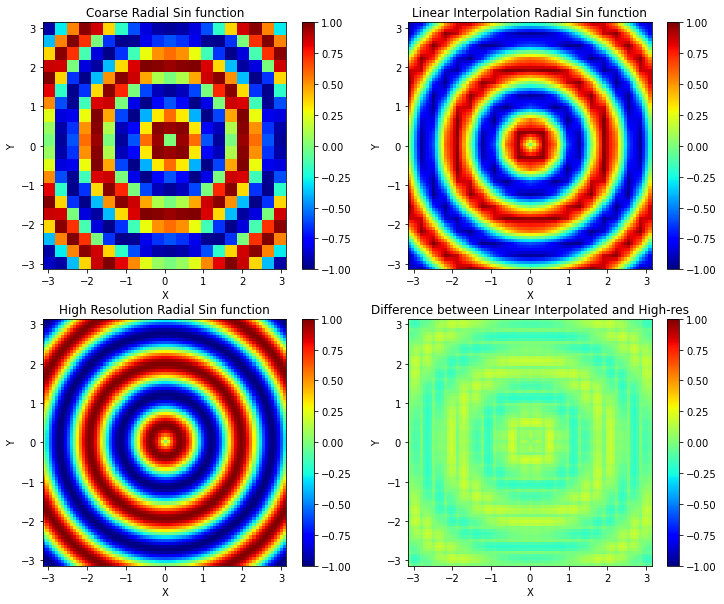

In [12]:
## . . Oscillation of radial sigma
sigma=4

## . . Make low-resolution mesh and fill with a sin function
x = np.arange(-np.pi, np.pi+np.pi/10, np.pi/10)
y = np.arange(-np.pi, np.pi+np.pi/10, np.pi/10)
xx, yy = np.meshgrid(x, y)

## . . Coarse radial sin function
z = make_radial_sin(xx,yy,sigma) 

## . . Use linear interpolation to move to finer grid
f_linear = interp.interp2d(x, y, z, kind='linear')

## . . Generate high-resolution mesh and perform linear interpolation
xnew = np.arange(-np.pi, np.pi+np.pi/40, np.pi/40)
ynew = np.arange(-np.pi, np.pi+np.pi/40, np.pi/40)
znew = f_linear(xnew, ynew)

## . . Now define the function on high-res grid
xxx, yyy = np.meshgrid(xnew, ynew)
zz = make_radial_sin(xxx,yyy,sigma)

## . . Plot function
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.pcolor(x,y,z,cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('Coarse Radial Sin function')
plt.colorbar()

plt.subplot(222)
plt.pcolor(xnew,ynew,znew,cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('Linear Interpolation Radial Sin function')
plt.colorbar()

plt.subplot(223)
plt.pcolor(xxx,yyy,zz,cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('High Resolution Radial Sin function')
plt.colorbar()

plt.subplot(224)
plt.pcolor(xxx,yyy,(zz-znew),cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('Difference between Linear Interpolated and High-res')
plt.colorbar()

plt.show()

## Bicubic (and higher) interpolation

Just as bilinear interpolation was the 2D analogue of 1D linear interpolation, [bicubic spline interpolation](https://en.wikipedia.org/wiki/Bicubic_interpolation) is the 2D analogue of 1D cubic spline interpolation.   In this case, say that you know the values of $f(Q_{ij})$ on the four corner of the unit square (e.g., $Q_{00}=(0,0)$,  $Q_{10}=(1,0)$, $Q_{01}=(0,1)$, and $Q_{11}=(1,1)$ as well as the first-order deriviatives $f_x$, $f_y$ and the second-order derivative $f_{xy}$. In this case, there is one and only one bicubic spline interpolant $p(x,y)$

$$p(x,y) = \sum\limits_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j, \tag{39} $$

where $a_{ij}$ are the to-be-determined polynomial coefficients that can fit all of these contraints.  The mathematics get somewhat tedious so I won't reproduce them here; however, if you are really wanting to know then the algorithm can be found [here](https://en.wikipedia.org/wiki/Bicubic_interpolation).

### Radial Sin Example

Let's now redo the example from above and look at how the spline interpolation results change as we use linear (left panels), cubic (middle panels) and quintic (right panels).  The upper panels show the interpolation results, while the lower panels show the difference between the interpolated results and the values of the exact function.  Clearly, the higher the order the better the results; however, there is a much larger difference betwee linear and cubic than there is between cubic and quintic.  Thus, even though even higher-order methods could be availble (e.g., septic, nonic), there is both a diminishing return in the interpolation quality as well as a significant increase in computational costs.

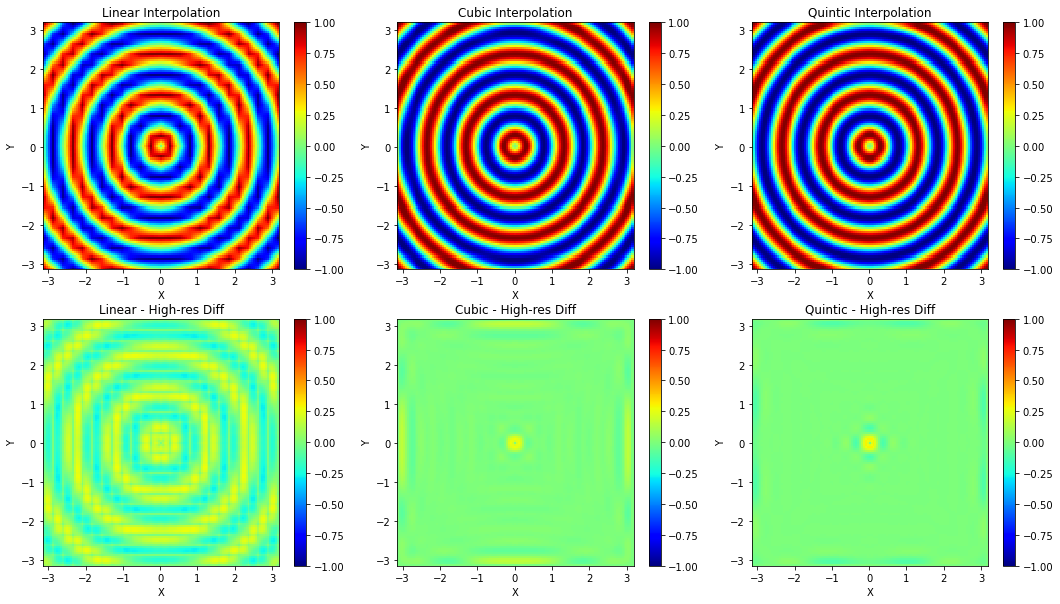

In [13]:
## . . Oscillation of radial sigma
sigma  = 6
losamp = 12
hisamp = 60

## . . Make low-resolution mesh and fill with a sin function
x = np.arange(-np.pi, np.pi+np.pi/losamp, np.pi/losamp)
y = np.arange(-np.pi, np.pi+np.pi/losamp, np.pi/losamp)
xx, yy = np.meshgrid(x, y)

## . . Coarse radial sin function
z = make_radial_sin(xx,yy,sigma) 

## . . Use cubic and quintic interpolation to move to finer grid
f_liner = interp.interp2d(x, y, z, kind='linear'  )
f_cubic = interp.interp2d(x, y, z, kind='cubic'  )
f_quint = interp.interp2d(x, y, z, kind='quintic')

## . . Generate high-resolution mesh and perform linear interpolation
xnew = np.arange(-np.pi, np.pi+np.pi/hisamp, np.pi/hisamp)
ynew = np.arange(-np.pi, np.pi+np.pi/hisamp, np.pi/hisamp)
z_liner = f_liner(xnew, ynew)
z_cubic = f_cubic(xnew, ynew)
z_quint = f_quint(xnew, ynew)

## . . Now define the function on high-res grid
xxx, yyy = np.meshgrid(xnew, ynew)
zz = make_radial_sin(xxx,yyy,sigma)

## . . Plot function
plt.figure(figsize=(18,10))

plt.subplot(231)
plt.pcolor(xnew,ynew,z_liner,cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('Linear Interpolation')
plt.colorbar()

plt.subplot(232)
plt.pcolor(xnew,ynew,z_cubic,cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('Cubic Interpolation')
plt.colorbar()

plt.subplot(233)
plt.pcolor(xxx,yyy,z_quint,cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('Quintic Interpolation')
plt.colorbar()

plt.subplot(234)
plt.pcolor(xxx,yyy,(zz-z_liner),cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('Linear - High-res Diff')
plt.colorbar()

plt.subplot(235)
plt.pcolor(xxx,yyy,(zz-z_cubic),cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('Cubic - High-res Diff')
plt.colorbar()

plt.subplot(236)
plt.pcolor(xxx,yyy,(zz-z_quint),cmap='jet',vmin=-1,vmax=1)
plt.xlabel('X');plt.ylabel('Y');
plt.title('Quintic - High-res Diff')
plt.colorbar()

plt.show()

# Handling Irregularly Sampled 2D Data

One persistent challenge when dealing geophysical datasets is handling those characterized by irregularly sampling.  While there are a number of different approaches for handling these scenarios, we'll close out this section by focusing on two different 2D interpolation types: splines and radial basis functions.

## Scipy Griddata Function

The *scipy.interpolate* toolkit has the *griddata* function that is used to used to generate regularly sampled 2D maps from irreguarly sampled data. The options for this are nearest neighbour (uses an optimized tree-search algorithm to find closest points), linear (performs Delaunay tesselation to find the best fitting triangle between three points) and cubic (returns the value determined from a piecewise cubic, continuously differentiable (C1), and approximately curvature-minimizing polynomial surface).  These involve higher-order interpolation methods then we need to cover in this course ... so let's just see how the perform in practice.

Below is an example using function

$$f(x,y) = x(1-x)\cos(4\pi x)\sin (4\pi y^2)^2, \tag{40} $$

where a random 1000 data points are extracted from an initially regularly sampled 100x200 point grid covering the unit square (i.e.,, $[0,1]\times[0,1]$. The upper left image shows the original high-resolution function with the black dots indicating the locations of the random samples.   The upper right image shows the result from nearest-neighbour interpolation, while the lower left and lower right panels show the 2D linear and 2D cubic interpolation results.  In this case, the 2D cubic algorithm does a fairly good job at representing the underlying 2D function $f(x,y)$.  Note that I have had to include the fill_value=0 to force values outside of the interpolation area to a non-NaN value. 

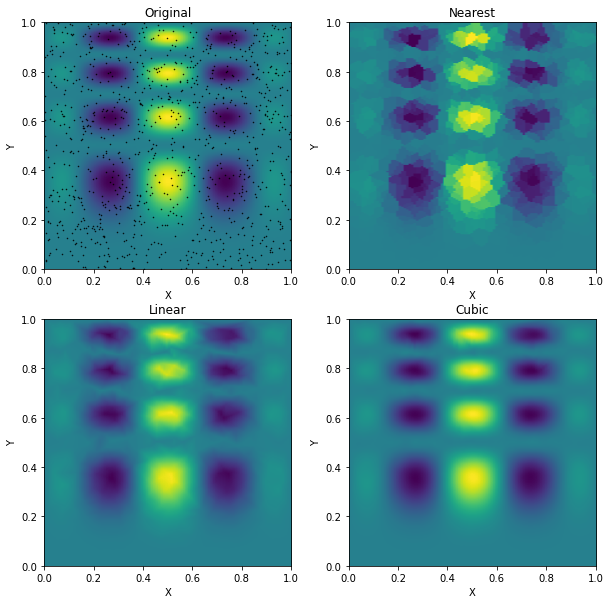

In [14]:
## . . Suppose we want to interpolate the 2-D function
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

## . . on a grid in [0, 1]x[0, 1]
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

## . . but we only know its values at 1000 data points:
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

## . . This can be done with griddata – below we try out all of the spline interpolation methods:
grid_z0 = interp.griddata(points, values, (grid_x, grid_y), method='nearest',fill_value=0)
grid_z1 = interp.griddata(points, values, (grid_x, grid_y), method='linear',fill_value=0)
grid_z2 = interp.griddata(points, values, (grid_x, grid_y), method='cubic',fill_value=0)

## . . One can see that the exact result is reproduced by all of the methods to some degree, 
## but for this smooth function the piecewise cubic interpolant gives the best results:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.xlabel('X');plt.ylabel('Y');

plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.xlabel('X');plt.ylabel('Y');

plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.xlabel('X');plt.ylabel('Y');

plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.xlabel('X');plt.ylabel('Y');

#plt.gcf().set_size_inches(6, 6)
plt.show()

## Radial Basis Functions

The final 2D interpolation method for irregularly sampled data is the [Radial Basis Function](https://en.wikipedia.org/wiki/Radial_basis_function).  Let's  recall one of the main motivations for using **polynomials**: integration or differentiation results in another polynomial, and that it is easy to laterally shift a polynomial by $a$ units by introducting $x \rightarrow x^\prime + a$.

Because of these nice properties, one can think of an interpolation polynomial, such as a 1D cubic expression,

$$f(x) = \sum_{n=0}^3 a_n x^n, \tag{41} $$

as some sort of **interpolation basis function**. (This is analogous to the $\sin$ and $\cos$ functions used in Fourier theory...)  However, there are numerous other functions that could be used as an **interpolation basis function**.  One of the leading classes is the [Radial Basis Function](https://en.wikipedia.org/wiki/Radial_basis_function), which represents a class of functions that satisfy $\varphi (\mathbf {x} )=\varphi (\left\|\mathbf {x} \right\|)$. Examples of these functions include:

* Gaussian: $\varphi (r)=e^{-(\varepsilon r)^2} \tag{42a}$
* Multiquadric: $\varphi (r)={\sqrt {1+(\varepsilon r)^{2}}} \tag{42b}$
* Inverse quadratic: $\varphi (r)={\dfrac {1}{1+(\varepsilon r)^{2}}} \tag{42c}$
* Inverse multiquadric: $\varphi (r)={\dfrac {1}{\sqrt {1+(\varepsilon r)^{2}}}} \tag{42d}$

The main idea is that by defining the choice of RBF basis function, one can then approximate a function $f(x)$ according to:

$$f(x)=\sum _{i=1}^{N}w_{i}\,\varphi (\left\|\mathbf {x} -\mathbf {x} _{i}\right\|), \tag{43}$$

where $w_i$ are weighting functions that must be chosen such that the corresponding sum optimally fit $f(x)$.


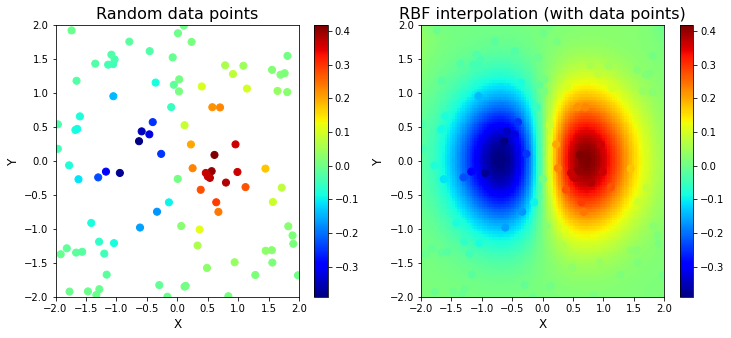

In [15]:
# 2-d tests - setup scattered data
x = np.random.rand(100)*4.0-2.0
y = np.random.rand(100)*4.0-2.0
z = x*np.exp(-x**2-y**2)

## . . Create regularly sampled output grid
ti = np.linspace(-2.0, 2.0, 100)
XI, YI = np.meshgrid(ti, ti)

# use RBF
rbf = interp.Rbf(x, y, z, function='inverse',epsilon=5)
ZI = rbf(XI, YI)

# plot the result
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(x, y, 50, z, cmap='jet')
plt.title('Random data points',fontsize=16)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('X',fontsize=12);plt.ylabel('Y',fontsize=12)
plt.colorbar()

plt.subplot(122)
plt.pcolor(XI, YI, ZI, cmap='jet')
plt.scatter(x, y, 50, z, cmap='jet',alpha=2)
plt.title('RBF interpolation (with data points)',fontsize=16)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('X',fontsize=12);plt.ylabel('Y',fontsize=12)
plt.colorbar()

plt.show()